In [2]:
pip install pandas matplotlib numpy seaborn


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


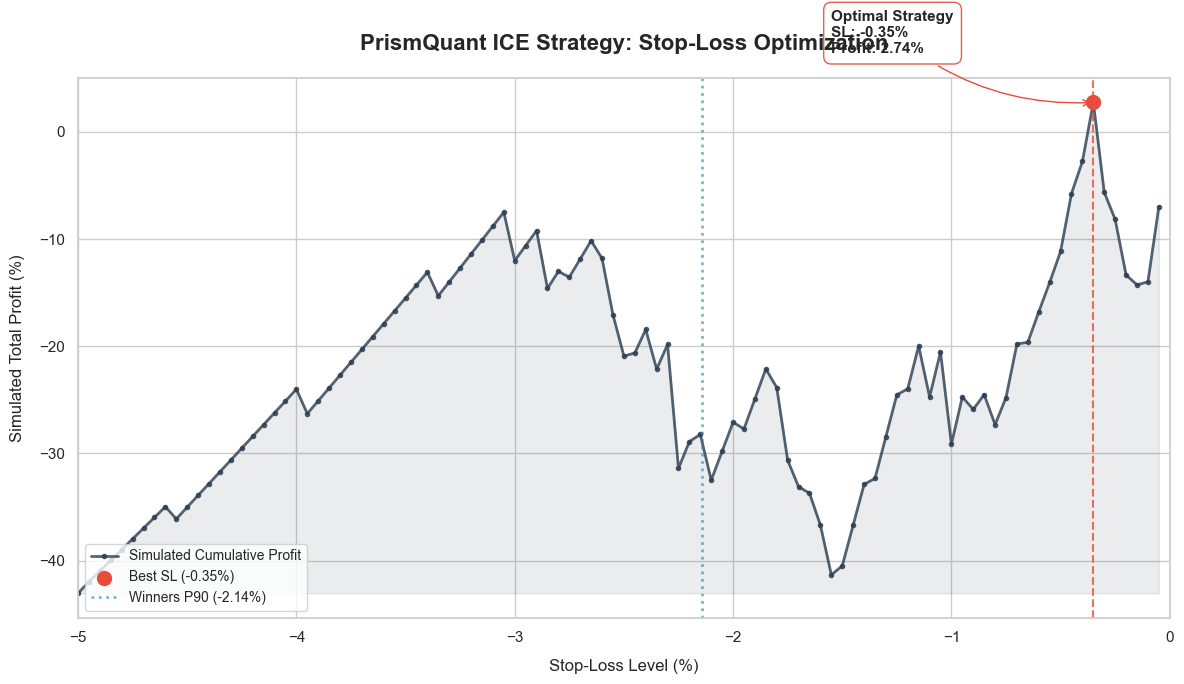


         PRISMQUANT STRATEGY OPTIMIZATION         
  [1] 수익 거래(Winners) 하락 내성 분석
    - 최적 하락 허용 한도 (P90) :    -2.14 %
    - 수익 거래 중 최대 하락폭   :    -2.54 %
--------------------------------------------------
  [2] 손절가(Stop-Loss) 최적화 결과
    - 최적 손절가 설정 (Best SL) :    -0.35 %
    - 예상 누적 수익률 (Total)   :     2.74 %
--------------------------------------------------
  [3] 데이터 기반 가이드라인
    * 현재 전략 성향: Aggressive(공격적)
    * 권장 사항: 손절가가 얕아 휩쏘(Whipsaw)에 의한 조기 청산 위험이 존재합니다.



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. 데이터 로드
# 사용자의 실제 경로로 수정하세요
file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_1m_0.004.csv'
df = pd.read_csv(file_path)

# 2. 컬럼 설정 및 전처리
COL_PROFIT = '순손익 %'
COL_MAE = '불리한 변동 %'
df = df.dropna(subset=[COL_PROFIT, COL_MAE])

# 3. 통계 계산 (수익 거래 MAE 분석)
winners = df[df[COL_PROFIT] > 0]
mae_winners = winners[COL_MAE]
p90_threshold = mae_winners.quantile(0.1)

# 4. 손절가 시뮬레이션 (Numpy 벡터 연산으로 고속화)
sl_range = np.arange(-0.05, -5.05, -0.05)
total_profits = []
profit_vals = df[COL_PROFIT].values
mae_vals = df[COL_MAE].values

for sl in sl_range:
    # MAE가 설정한 SL보다 깊게 내려갔다면 SL로 대체, 아니면 원래 수익 유지
    simulated_p = np.where(mae_vals <= sl, sl, profit_vals)
    total_profits.append(simulated_p.sum())

total_profits = np.array(total_profits)
best_idx = np.argmax(total_profits)
best_sl = sl_range[best_idx]
best_profit = total_profits[best_idx]

# 5. 시각화 (Seaborn 테마 적용)
sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 7))

# 메인 수익 곡선 및 영역 채우기
plt.plot(sl_range, total_profits, marker='o', markersize=3, 
         color='#2c3e50', linewidth=2, label='Simulated Cumulative Profit', alpha=0.8)
plt.fill_between(sl_range, total_profits, min(total_profits), alpha=0.1, color='#34495e')

# 최적 손절 지점 하이라이트
plt.axvline(best_sl, color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.8)
plt.scatter(best_sl, best_profit, color='#e74c3c', s=100, zorder=5, label=f'Best SL ({best_sl:.2f}%)')

# P90 (수익 거래의 90% 생존 지점) 표시
plt.axvline(p90_threshold, color='#2980b9', linestyle=':', linewidth=2, alpha=0.6, 
            label=f'Winners P90 ({p90_threshold:.2f}%)')

# 세련된 어노테이션 상자
plt.annotate(f'Optimal Strategy\nSL: {best_sl:.2f}%\nProfit: {best_profit:.2f}%',
             xy=(best_sl, best_profit),
             xytext=(best_sl - 1.2, best_profit + (max(total_profits) - min(total_profits)) * 0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
             fontsize=11, fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#e74c3c", alpha=0.9))

# 타이틀 및 레이블 설정
plt.title('PrismQuant ICE Strategy: Stop-Loss Optimization', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Stop-Loss Level (%)', fontsize=12, labelpad=10)
plt.ylabel('Simulated Total Profit (%)', fontsize=12, labelpad=10)

# X축 포맷 (0%에서 -5% 방향으로)
plt.xlim(0, -5.0)
plt.gca().invert_xaxis()
plt.legend(frameon=True, fontsize=10, loc='lower left')

plt.tight_layout()
plt.show()

# 6. 터미널 결과 출력
# --- [PrismQuant Strategy: Optimization Report] ---
line_width = 50
print("\n" + "=" * line_width)
print(f"{'PRISMQUANT STRATEGY OPTIMIZATION':^50}")
print("=" * line_width)

# 1. 핵심 통계 요약 (Key Statistics)
print(f"  [1] 수익 거래(Winners) 하락 내성 분석")
print(f"    - 최적 하락 허용 한도 (P90) : {p90_threshold:>8.2f} %")
print(f"    - 수익 거래 중 최대 하락폭   : {mae_winners.min():>8.2f} %")
print("-" * line_width)

# 2. 최적 손절 시뮬레이션 결과 (Simulation Results)
print(f"  [2] 손절가(Stop-Loss) 최적화 결과")
print(f"    - 최적 손절가 설정 (Best SL) : {best_sl:>8.2f} %")
print(f"    - 예상 누적 수익률 (Total)   : {best_profit:>8.2f} %")
print("-" * line_width)

# 3. 전략 인사이트 (Strategy Insights)
print(f"  [3] 데이터 기반 가이드라인")
is_conservative = abs(best_sl) > abs(p90_threshold)
risk_profile = "Conservative(보수적)" if is_conservative else "Aggressive(공격적)"

print(f"    * 현재 전략 성향: {risk_profile}")
print(f"    * 권장 사항: ", end="")
if is_conservative:
    print(f"P90({p90_threshold:.2f}%)보다 손절가가 깊어 수익 거래 보존율이 높습니다.")
else:
    print(f"손절가가 얕아 휩쏘(Whipsaw)에 의한 조기 청산 위험이 존재합니다.")

print("=" * line_width + "\n")

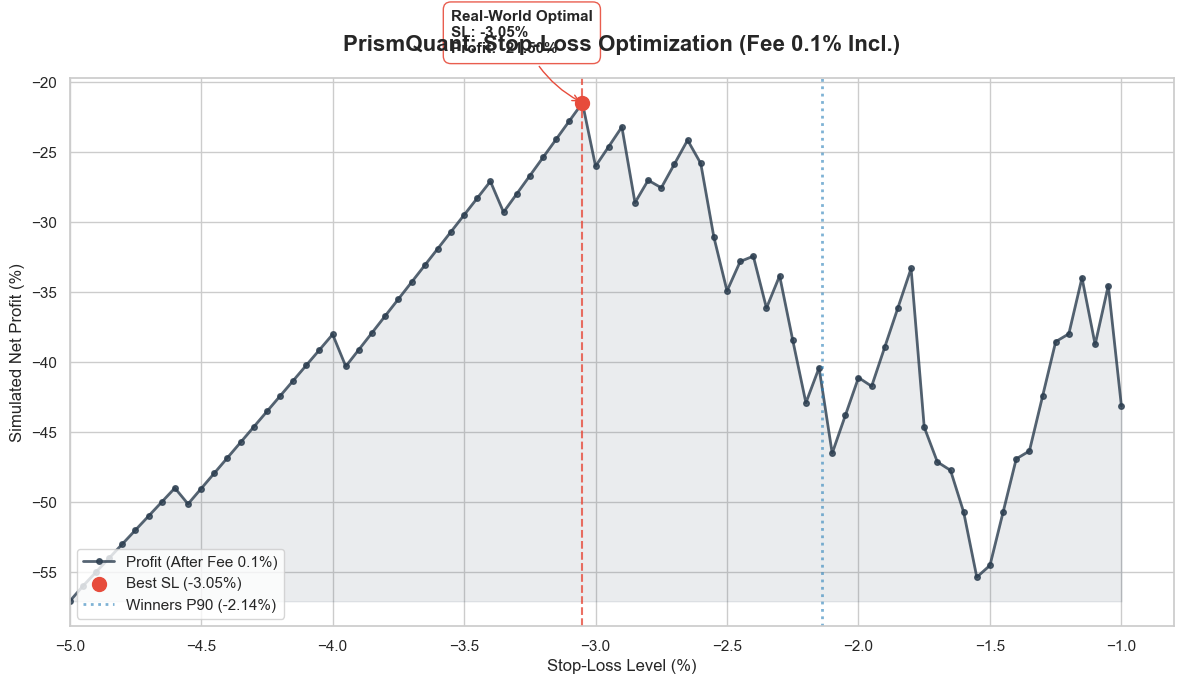


         PRISMQUANT STRATEGY REAL-WORLD REPORT         
  [1] 수익 거래(Winners) 내성 분석
    - 수익 거래 90% 생존 하락폭 (P90) :    -2.14 %
    - 수익 거래 중 최대 하락 경험     :    -2.54 %
-------------------------------------------------------
  [2] 실전 최적화 시뮬레이션 (왕복 수수료 0.1% 포함)
    - 실전 권장 손절가 (Best SL)      :    -3.05 %
    - 수수료 차감 후 예상 총수익      :   -21.50 %
-------------------------------------------------------
  [3] 퀀트 코멘트
    ✅ 안정: 최적 손절가가 P90을 커버합니다.
       추세 반전 전까지 포지션 유지가 유리한 구조입니다.



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. 데이터 로드
file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_1m_0.004.csv'
df = pd.read_csv(file_path)

# 2. 컬럼 설정 및 수수료 정의
COL_PROFIT = '순손익 %'
COL_MAE = '불리한 변동 %'
FEE = 0.0005 * 2  # 왕복 수수료 0.1% 반영
df = df.dropna(subset=[COL_PROFIT, COL_MAE])

# 3. 수익 거래 MAE 분석
winners = df[df[COL_PROFIT] > 0]
mae_winners = winners[COL_MAE]
p90_threshold = mae_winners.quantile(0.1)

# 4. 손절가 시뮬레이션 (수정: 실전성을 위해 -1.0%부터 탐색)
# 너무 얕은 손절(0.35% 등)은 수수료와 휩쏘 때문에 실전성이 떨어짐을 반영
sl_range = np.arange(-1.0, -5.05, -0.05) 
total_profits = []

profit_vals = df[COL_PROFIT].values
mae_vals = df[COL_MAE].values

for sl in sl_range:
    # 수수료 반영 로직: 손절 시 sl 적용, 미발생 시 원래 수익 적용 후 공통 수수료 차감
    simulated_p = np.where(mae_vals <= sl, sl, profit_vals)
    total_profits.append((simulated_p - (FEE * 100)).sum()) # 수수료(%) 차감 후 합산

total_profits = np.array(total_profits)
best_idx = np.argmax(total_profits)
best_sl = sl_range[best_idx]
best_profit = total_profits[best_idx]

# 5. 시각화 (Seaborn 테마)
sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(12, 7))

# 누적 수익 곡선
plt.plot(sl_range, total_profits, marker='o', markersize=4, 
         color='#2c3e50', linewidth=2, label='Profit (After Fee 0.1%)', alpha=0.8)
plt.fill_between(sl_range, total_profits, min(total_profits), alpha=0.1, color='#34495e')

# 최적 및 P90 지점 표시
plt.axvline(best_sl, color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.8)
plt.scatter(best_sl, best_profit, color='#e74c3c', s=100, zorder=5, label=f'Best SL ({best_sl:.2f}%)')
plt.axvline(p90_threshold, color='#2980b9', linestyle=':', linewidth=2, alpha=0.6, 
            label=f'Winners P90 ({p90_threshold:.2f}%)')

# 어노테이션
plt.annotate(f'Real-World Optimal\nSL: {best_sl:.2f}%\nProfit: {best_profit:.2f}%',
             xy=(best_sl, best_profit),
             xytext=(best_sl - 0.5, best_profit + (max(total_profits)-min(total_profits))*0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='#e74c3c'),
             fontsize=11, fontweight='bold', bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#e74c3c", alpha=0.9))

plt.title('PrismQuant: Stop-Loss Optimization (Fee 0.1% Incl.)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Stop-Loss Level (%)', fontsize=12)
plt.ylabel('Simulated Net Profit (%)', fontsize=12)
plt.xlim(-0.8, -5.0)
plt.gca().invert_xaxis()
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 6. 리포트 출력
line_width = 55
print("\n" + "=" * line_width)
print(f"{'PRISMQUANT STRATEGY REAL-WORLD REPORT':^55}")
print("=" * line_width)
print(f"  [1] 수익 거래(Winners) 내성 분석")
print(f"    - 수익 거래 90% 생존 하락폭 (P90) : {p90_threshold:>8.2f} %")
print(f"    - 수익 거래 중 최대 하락 경험     : {mae_winners.min():>8.2f} %")
print("-" * line_width)
print(f"  [2] 실전 최적화 시뮬레이션 (왕복 수수료 0.1% 포함)")
print(f"    - 실전 권장 손절가 (Best SL)      : {best_sl:>8.2f} %")
print(f"    - 수수료 차감 후 예상 총수익      : {best_profit:>8.2f} %")
print("-" * line_width)
print(f"  [3] 퀀트 코멘트")
if abs(best_sl) < abs(p90_threshold):
    print(f"    ⚠️ 경고: 최적 손절가가 P90보다 얕습니다.\n       수익 거래가 노이즈에 잘릴 위험이 매우 높습니다.")
else:
    print(f"    ✅ 안정: 최적 손절가가 P90을 커버합니다.\n       추세 반전 전까지 포지션 유지가 유리한 구조입니다.")
print("=" * line_width + "\n")

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 로드
file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_1m_0.004.csv'
# file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_15m.csv'
df = pd.read_csv(file_path)

COL_PROFIT = '순손익 %'
COL_MAE = '불리한 변동 %'

def run_sl_analysis(target_sl):
    sim_df = df.copy()
    
    # MAE는 음수이므로 target_sl보다 "작거나 같으면" 손절 발생
    sim_df['Simulated_Profit'] = np.where(
        sim_df[COL_MAE] <= target_sl, 
        target_sl, 
        sim_df[COL_PROFIT]
    )
    
    orig_total = sim_df[COL_PROFIT].sum()
    sim_total = sim_df['Simulated_Profit'].sum()
    orig_win_rate = (sim_df[COL_PROFIT] > 0).mean() * 100
    sim_win_rate = (sim_df['Simulated_Profit'] > 0).mean() * 100
    stop_loss_tripped = (sim_df[COL_MAE] <= target_sl).sum()
    
    return {
        "target_sl": target_sl,
        "orig_total": orig_total,
        "sim_total": sim_total,
        "improvement": sim_total - orig_total,
        "orig_win_rate": orig_win_rate,
        "sim_win_rate": sim_win_rate,
        "stop_count": stop_loss_tripped
    }

# 2. 분석 실행 (양수 값들을 음수로 변경하고 중복 루프 제거)
# 손절은 가격이 깎이는 것이므로 마이너스(-) 값을 넣어야 합니다.
# sl_candidates = [-3.85, -4.5, -5.0, -5.5, -6.0, -6.5, -7.0, -7.5, -8.0, -8.5, -9.0, -9.5, -10.0]
sl_candidates = [-0.35,
    -1.2, -1.4, -1.6, -1.8, -2.0, -2.2, -2.4, -2.6, -2.8, -3.0,-3.1,-3.05,
    -3.2, -3.4, -3.8, -4.0, -4.2, -4.4, -4.6, -4.8, -5.0, -5.2, 
    -5.4, -5.6, -5.8, -6.0, -6.2, -6.4, -6.6, -6.8, -7.0, -7.2, 
    -7.4, -7.6, -7.8, -8.0, -8.2, -8.4, -8.6, -8.8, -9.0, -9.2, 
    -9.4, -9.6, -9.8, -10.0
]

# sl_candidates = [-1.2, -1.4, -1.6, -1.8, -2.0, -2.2, -2.4, -2.6, -2.8, -3.0, -3.2, -3.4, -3.8, -4.0]

print(f"{'손절가':>8} | {'총수익':>10} | {'수익개선':>10} | {'승률':>8} | {'손절횟수':>8}")
print("-" * 60)

for sl in sl_candidates:
    res = run_sl_analysis(sl)
    
    # 결과 요약 출력
    status = "✅" if res['improvement'] > 0 else "❌"
    print(f"{res['target_sl']:>8.2f}% | {res['sim_total']:>9.2f}% | {res['improvement']:>9.2f}%p | {res['sim_win_rate']:>7.1f}% | {res['stop_count']:>6}회 {status}")

     손절가 |        총수익 |       수익개선 |       승률 |     손절횟수
------------------------------------------------------------


KeyError: '불리한 변동 %'

In [6]:
import pandas as pd

# 데이터 로드
# file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_V3_OKX_BTCUSDT.P_2026-02-23_loss4.csv'
# file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_15m.csv'
file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_V3_OKX_BTCUSDT.P_2026-02-23_1m_loss100.csv'

df = pd.read_csv(file_path)

# 설정값
contract_qty = 0.004      # 기본 계약 수량
contract_krw = 375029     # 1계약당 필요 원화 (증거금 기준 아님)
leverage = 10             # 사용 레버리지

# 진입 데이터 필터링 및 연속성 계산
entries = df[df['타입'].str.contains('진입')].copy()
entries['Direction'] = entries['타입'].str.split().str[0]
entries['Group'] = (entries['Direction'] != entries['Direction'].shift()).cumsum()
consecutive_counts = entries.groupby(['Group', 'Direction']).size()

# 통계치 추출
max_buy = consecutive_counts[consecutive_counts.index.get_level_values('Direction') == '매수'].max()
max_sell = consecutive_counts[consecutive_counts.index.get_level_values('Direction') == '매도'].max()
max_total = max(max_buy, max_sell)

# 금액 계산
max_notional_value = contract_krw * max_total        # 최대 총 포지션 가치
required_margin = max_notional_value / leverage      # 레버리지 적용 필요 증거금
safe_margin = required_margin * 1.5                  # 변동성 대비 권장 여유 자금(150%)

# 리포트 출력
print("="*50)
print(f"{' [ PrismQuant 자금 관리 리포트 ] ':^46}")
print("="*50)
print(f" ▷ 기본 계약 수량 : {contract_qty} BTC")
print(f" ▷ 사용 레버리지   : {leverage}배")
print("-" * 50)
print(f" ▷ 최대 연속 진입 (매수) : {max_buy:>3} 회")
print(f" ▷ 최대 연속 진입 (매도) : {max_sell:>3} 회")
print(f" ▷ 평균 연속 진입 횟수   : {consecutive_counts.mean():>3.1f} 회")
print("-" * 50)
print(f" ▷ 최대 포지션 가치     : {max_notional_value:,.0f} KRW")
print(f" ▷ 최소 필요 증거금     : {required_margin:,.0f} KRW")
print(f" ▷ 권장 보증금 (1.5배)  : {safe_margin:,.0f} KRW")
print("="*50)
print(f" ※ {max_total}회 연속 진입 시에도 {required_margin:,.0f}원만 있으면 운영 가능합니다.")
print("="*50)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_V3_OKX_BTCUSDT.P_2026-02-23_1m_loss100.csv'

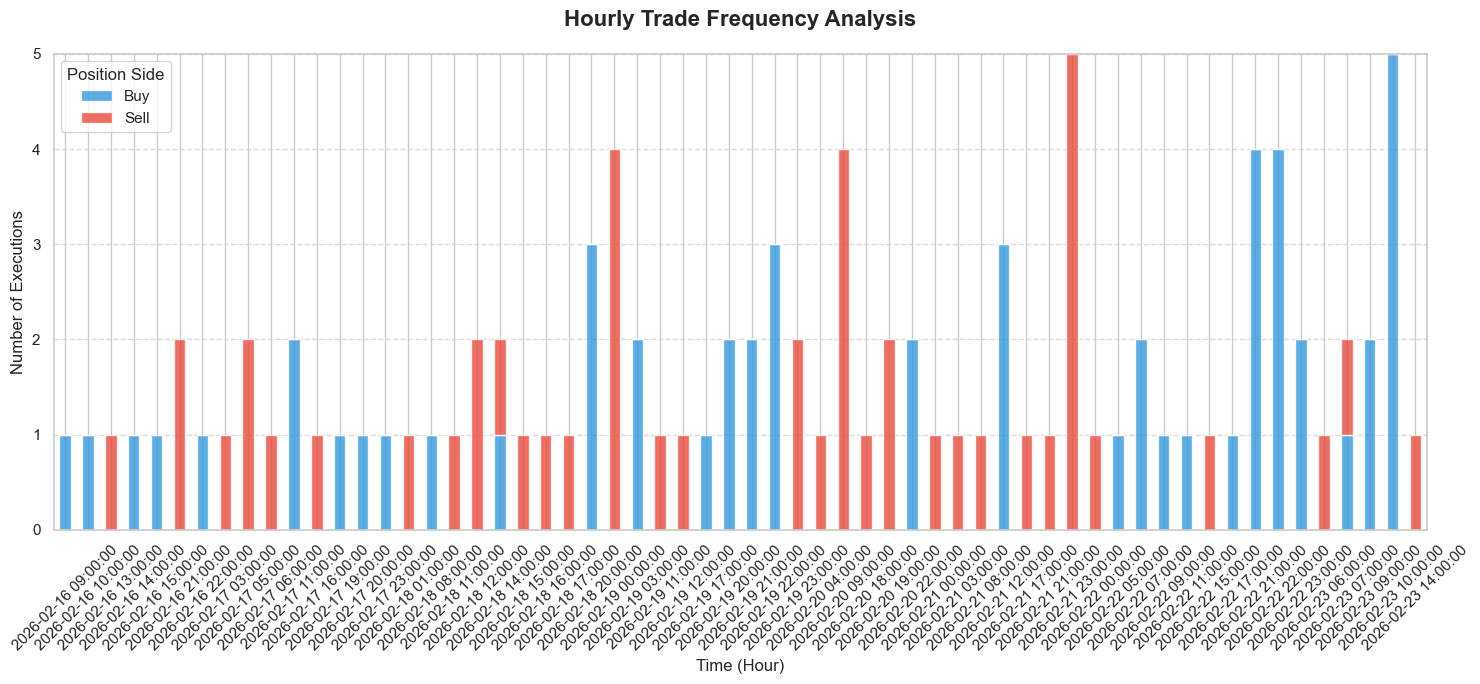


                  STRATEGY DEEP ANALYSIS REPORT                  
  [SECTION A] 운영 요약 (Operational Summary)
  - 파일 정보      : PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_30s_0.004.csv
  - 분석 기간      : 2026-02-16 09:45:00 ~ 2026-02-23 14:05:00
  - 총 진입 횟수   :        101 회
  - 포지션 밸런스  : 매수 53.5% | 매도 46.5%
-----------------------------------------------------------------
  [SECTION B] 실행 밀도 분석 (Execution Density)
  - 시간당 평균 진입 :       1.68 회
  - 평균 진입 간격   :     103.40 분 (Trade-to-Trade)
  - 10분당 최대 밀도 :          5 회 (부하 구간)
-----------------------------------------------------------------
  [SECTION C] 트래픽 피크 및 노이즈 검측
  - 최다 실행 시간대 : 2026-02-21 23:00:00
  - 피크 타임 빈도   :          5 회 / Hour
-----------------------------------------------------------------
  [SECTION D] 퀀트 인사이트 (Insights)
  ⚠️ 주의: 10분 내 5회 이상 진입 발생. 휩쏘(Whipsaw) 구간 감지.
           슬리피지 비용이 누적 수익을 갉아먹을 수 있습니다.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드 및 전처리
file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_30s_0.004.csv'
df = pd.read_csv(file_path)

# 날짜 컬럼을 datetime 객체로 변환
df['날짜 및 시간'] = pd.to_datetime(df['날짜 및 시간'])
df = df.set_index('날짜 및 시간')

# 진입(Entry) 데이터만 추출
entry_df = df[df['타입'].str.contains('진입')].copy()

# 매수/매도 구분 컬럼 생성 (L=Buy, S=Sell)
entry_df['Side'] = entry_df['신호'].apply(lambda x: 'Buy' if str(x).startswith('L') else 'Sell')

# 2. 시간대별 분석 함수 (빈도 약어 수정: T -> min)
def analyze_frequency(data, freq_str):
    # 시간 단위로 그룹화하여 Side별 개수 계산
    count_df = data.groupby([pd.Grouper(freq=freq_str), 'Side']).size().unstack(fill_value=0)
    
    # Side 컬럼이 하나만 있을 경우를 대비해 부족한 컬럼 채우기
    for side in ['Buy', 'Sell']:
        if side not in count_df.columns:
            count_df[side] = 0
            
    count_df['Total'] = count_df['Buy'] + count_df['Sell']
    return count_df

# 에러 해결 포인트: '1T' -> '1min', '10T' -> '10min', 'H' -> 'h'
min_freq = analyze_frequency(entry_df, '1min')
ten_min_freq = analyze_frequency(entry_df, '10min')
hour_freq = analyze_frequency(entry_df, 'h')

# 3. 시각화 (시간당 거래 빈도)
sns.set_theme(style="whitegrid", palette="muted")
plt.figure(figsize=(15, 7))

# 시간당 매수/매도 거래 횟수 막대 그래프 (색상: 파랑/빨강)
hour_freq[['Buy', 'Sell']].plot(kind='bar', stacked=True, ax=plt.gca(), color=['#3498db', '#e74c3c'], alpha=0.8)

plt.title('Hourly Trade Frequency Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time (Hour)', fontsize=12)
plt.ylabel('Number of Executions', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Position Side', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. 분석 결과 요약 출력
# --- [PrismQuant Strategy: Advanced Execution Report] ---
line_width = 65
avg_interval = (entry_df.index.to_series().diff().mean().total_seconds() / 60) # 평균 진입 간격(분)
buy_ratio = (entry_df['Side'].value_counts().get('Buy', 0) / len(entry_df)) * 100
sell_ratio = (entry_df['Side'].value_counts().get('Sell', 0) / len(entry_df)) * 100

print("\n" + "=" * line_width)
print(f"{'STRATEGY DEEP ANALYSIS REPORT':^65}")
print("=" * line_width)

# 1. 기본 운용 현황
print(f"  [SECTION A] 운영 요약 (Operational Summary)")
print(f"  - 파일 정보      : {file_path.split('/')[-1]}")
print(f"  - 분석 기간      : {entry_df.index.min()} ~ {entry_df.index.max()}")
print(f"  - 총 진입 횟수   : {len(entry_df):>10,} 회")
print(f"  - 포지션 밸런스  : 매수 {buy_ratio:.1f}% | 매도 {sell_ratio:.1f}%")
print("-" * line_width)

# 2. 실행 밀도 및 속도 분석
print(f"  [SECTION B] 실행 밀도 분석 (Execution Density)")
print(f"  - 시간당 평균 진입 : {hour_freq['Total'].mean():>10.2f} 회")
print(f"  - 평균 진입 간격   : {avg_interval:>10.2f} 분 (Trade-to-Trade)")
print(f"  - 10분당 최대 밀도 : {ten_min_freq['Total'].max():>10} 회 (부하 구간)")
print("-" * line_width)

# 3. 이상 징후 및 피크 타임
print(f"  [SECTION C] 트래픽 피크 및 노이즈 검측")
peak_time = hour_freq['Total'].idxmax()
peak_count = hour_freq['Total'].max()
print(f"  - 최다 실행 시간대 : {peak_time}")
print(f"  - 피크 타임 빈도   : {peak_count:>10} 회 / Hour")

# 4. 전략 인사이트 코멘트
print("-" * line_width)
print(f"  [SECTION D] 퀀트 인사이트 (Insights)")

# 10분당 5회 진입은 30초 단위 데이터에서 상당히 높은 빈도입니다.
if ten_min_freq['Total'].max() >= 5:
    print(f"  ⚠️ 주의: 10분 내 5회 이상 진입 발생. 휩쏘(Whipsaw) 구간 감지.")
    print(f"           슬리피지 비용이 누적 수익을 갉아먹을 수 있습니다.")
else:
    print(f"  ✅ 안정: 진입 빈도가 안정적입니다. 오버트레이딩 위험이 낮습니다.")

if abs(buy_ratio - 50) > 15:
    print(f"  ⚠️ 주의: 방향성 편향(Bias) 감지. 한쪽 포지션에 쏠려 있습니다.")

print("=" * line_width + "\n")

In [5]:
import pandas as pd
import numpy as np

# 1. 데이터 로드 및 경로 설정 (여기에 실제 경로를 입력하세요)
file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-23_30s_0.004.csv'
df = pd.read_csv(file_path)

# 날짜 변환 및 진입 데이터 필터링
df['날짜 및 시간'] = pd.to_datetime(df['날짜 및 시간'])
entry_df = df[df['타입'].str.contains('진입')].sort_values('날짜 및 시간').copy()

# 매수/매도 구분 (L=Buy, S=Sell)
entry_df['Side'] = entry_df['신호'].apply(lambda x: 'Buy' if str(x).startswith('L') else 'Sell')

# 2. 연속 신호 시퀀스 분석 함수
def get_sequence_counts(side_label):
    counts = []
    temp_count = 0
    for s in entry_df['Side']:
        if s == side_label:
            temp_count += 1
        else:
            if temp_count > 0:
                counts.append(temp_count)
            temp_count = 0
    if temp_count > 0: counts.append(temp_count)
    return pd.Series(counts) if counts else pd.Series([0])

buy_seq = get_sequence_counts('Buy')
sell_seq = get_sequence_counts('Sell')

# 3. 평균 진입 간격 계산 (Timedelta 오류 방지 로직)
diffs = entry_df.index.to_series().diff().dropna()
# 인덱스가 시계열이 아닐 경우를 대비해 '날짜 및 시간' 컬럼으로 직접 계산
diffs = entry_df['날짜 및 시간'].diff().dropna()
avg_interval_min = diffs.dt.total_seconds().mean() / 60 if not diffs.empty else 0

# 4. 심층 전략 리포트 출력
line_width = 75
print("\n" + "=" * line_width)
print(f"{'PRISMQUANT: POSITION SCALING & RISK MANAGEMENT':^75}")
print("=" * line_width)

# [SECTION A] 🟢 롱 포지션 (Long) 대응 전략
print(f"  [STRATEGY 1] 🟢 롱 포지션 보유 (LONG)")
print(f"  - 평균 연속 신호 발생 : {buy_seq.mean():.1f} 회")
print(f"  - 공격적 분할 매도 시점 : {max(1, int(buy_seq.quantile(0.5)))}회차 추가 신호 시 비중 30% 축소")
print(f"  - 보수적 익절 권고     : {max(1, int(buy_seq.min()))}회차(진입 즉시)부터 목표가 도달 시 분할")
print("-" * line_width)

# [SECTION B] 🔴 숏 포지션 (Short) 대응 전략
print(f"  [STRATEGY 2] 🔴 숏 포지션 보유 (SHORT)")
print(f"  - 평균 연속 신호 발생 : {sell_seq.mean():.1f} 회")
print(f"  - 공격적 분할 매도 시점 : {max(1, int(sell_seq.quantile(0.5)))}회차 추가 신호 시 비중 30% 축소")
print(f"  - 보수적 익절 권고     : {max(1, int(sell_seq.min()))}회차(진입 즉시)부터 목표가 도달 시 분할")
print("-" * line_width)

# [SECTION C] ⚠️ 퀀트 기반 보수적 가이드 (Conservative Insight)
print(f"  [SECTION C] 실행 리스크 가이드")
print(f"  * 평균 신호 대기 시간 : {avg_interval_min:.1f} 분")
print(f"  * [보수적 관점] 반대 신호가 평균 {min(buy_seq.mean(), sell_seq.mean()):.1f}회 신호 주기 내에 발생합니다.")
print(f"    - 신호가 겹칠 때(2회차)를 기다리기보다 '수익 구간 진입 시' 즉시 일부 실현을 권장합니다.")
print(f"  * [시간 리스크] 포지션 진입 후 {avg_interval_min * 1.5:.1f}분 동안 추가 신호가 없다면,")
print(f"    추세가 약화된 것으로 판단하고 보수적으로 비중을 줄이십시오.")
print("=" * line_width + "\n")


              PRISMQUANT: POSITION SCALING & RISK MANAGEMENT               
  [STRATEGY 1] 🟢 롱 포지션 보유 (LONG)
  - 평균 연속 신호 발생 : 3.4 회
  - 공격적 분할 매도 시점 : 2회차 추가 신호 시 비중 30% 축소
  - 보수적 익절 권고     : 1회차(진입 즉시)부터 목표가 도달 시 분할
---------------------------------------------------------------------------
  [STRATEGY 2] 🔴 숏 포지션 보유 (SHORT)
  - 평균 연속 신호 발생 : 2.9 회
  - 공격적 분할 매도 시점 : 2회차 추가 신호 시 비중 30% 축소
  - 보수적 익절 권고     : 1회차(진입 즉시)부터 목표가 도달 시 분할
---------------------------------------------------------------------------
  [SECTION C] 실행 리스크 가이드
  * 평균 신호 대기 시간 : 103.4 분
  * [보수적 관점] 반대 신호가 평균 2.9회 신호 주기 내에 발생합니다.
    - 신호가 겹칠 때(2회차)를 기다리기보다 '수익 구간 진입 시' 즉시 일부 실현을 권장합니다.
  * [시간 리스크] 포지션 진입 후 155.1분 동안 추가 신호가 없다면,
    추세가 약화된 것으로 판단하고 보수적으로 비중을 줄이십시오.




 📈 PRISMQUANT V3 : STRATEGY EDGE ANALYSIS REPORT
 [데이터 요약]
  • 포지션 타입       : Entry Long
  • 총 진입 횟수      : 58회
-------------------------------------------------------
 [핵심 엣지(Edge) 지표]
  • 평균 MFE (순행)   : +1.21%
  • 평균 MAE (역행)   : -2.04%
  • E-Ratio          : 0.59 ⚠️ (불리한 타점)
-------------------------------------------------------
 [시뮬레이션 결과 (TP 2.0%, SL 2.0%, 왕복 수수료 0.1%)]
  • 청산 도달 횟수    : 총 32회 (미도달 26회)
  • 승 / 패           : 10 Win / 22 Loss
  • 추정 승률(Win Rate): 31.25%
  • 프로핏 팩터(PF)   : 0.45
  • 1회당 기댓값(EV)  : -0.850%



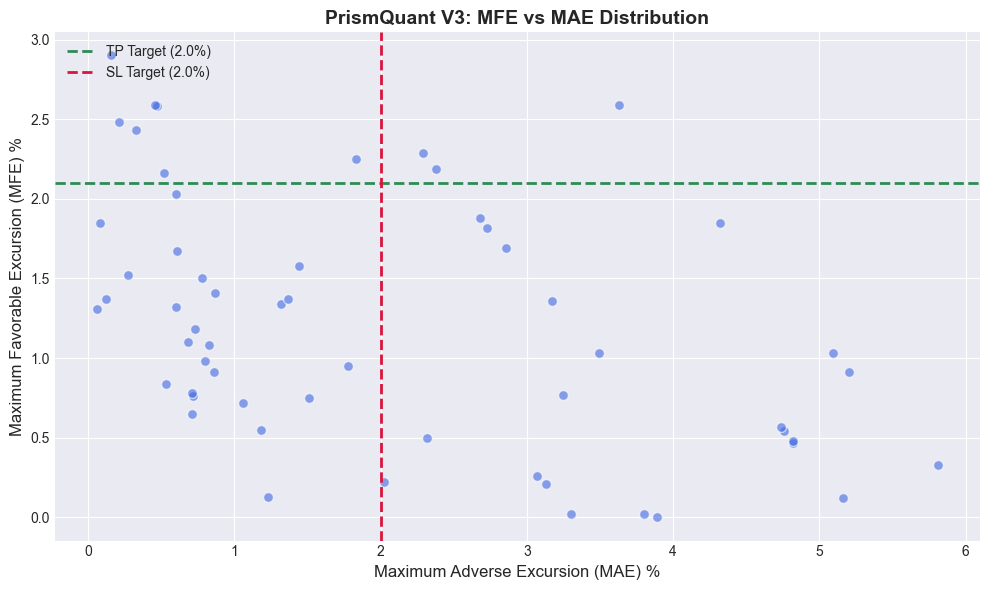

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def evaluate_prismquant_edge():
    # 1. 파일 경로 및 데이터 로드
    file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_V3_OKX_BTCUSDT.P_2026-02-24_1m_0.004.csv'
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요:\n{file_path}")
        return

    # 2. 'Entry long' 진입 데이터만 필터링
    entries = df[df['Type'] == 'Entry long'].copy()
    
    if entries.empty:
        print("❌ 'Entry long' 데이터가 없습니다. CSV 파일의 'Type' 컬럼을 확인해주세요.")
        return

    # 💡 수정된 부분: 실제 CSV 파일의 컬럼명으로 정확히 매핑
    fav_col = 'Favorable excursion %'
    adv_col = 'Adverse excursion %'

    try:
        # 데이터 타입 변환 및 계산 (결측치 제거 및 MAE 절대값 처리)
        mfe_series = pd.to_numeric(entries[fav_col], errors='coerce').dropna()
        mae_series = pd.to_numeric(entries[adv_col], errors='coerce').dropna().abs()
        
        mfe_mean = mfe_series.mean()
        mae_mean = mae_series.mean()
    except KeyError as e:
        print(f"❌ 컬럼을 찾을 수 없습니다: {e}")
        print("현재 CSV 파일의 컬럼명 목록:", df.columns.tolist())
        return

    # E-Ratio (Edge Ratio) 계산
    e_ratio = mfe_mean / mae_mean if mae_mean != 0 else np.inf

    # 3. 고정 손익비 백테스트 (왕복 0.1% 반영)
    round_trip_fee = 0.1 
    target_profit = 2.0  # 목표 익절 2%
    stop_loss = 2.0      # 목표 손절 -2%
    
    wins = 0
    losses = 0
    
    # MFE와 MAE를 비교하여 가상 매매 승패 판별
    for mfe, mae in zip(mfe_series, mae_series):
        if mfe >= (target_profit + round_trip_fee):
            wins += 1
        elif mae >= stop_loss:
            losses += 1
            
    total_trades = wins + losses
    win_rate = (wins / total_trades * 100) if total_trades > 0 else 0
    
    # 추가 분석 지표: Profit Factor 및 1회 거래당 기댓값(Expected Value)
    gross_profit = wins * target_profit
    gross_loss = losses * stop_loss
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    expected_value = (win_rate / 100 * target_profit) - ((1 - win_rate / 100) * stop_loss) - round_trip_fee

    # 4. 프로페셔널 분석 리포트 출력
    print("\n" + "="*55)
    print(" 📈 PRISMQUANT V3 : STRATEGY EDGE ANALYSIS REPORT")
    print("="*55)
    print(f" [데이터 요약]")
    print(f"  • 포지션 타입       : Entry Long")
    print(f"  • 총 진입 횟수      : {len(entries):,}회")
    print("-"*55)
    print(f" [핵심 엣지(Edge) 지표]")
    print(f"  • 평균 MFE (순행)   : +{mfe_mean:.2f}%")
    print(f"  • 평균 MAE (역행)   : -{mae_mean:.2f}%")
    
    # E-Ratio 직관적 평가 추가
    edge_eval = "✅ (통계적 우위)" if e_ratio >= 1.0 else "⚠️ (불리한 타점)"
    print(f"  • E-Ratio          : {e_ratio:.2f} {edge_eval}")
    print("-"*55)
    print(f" [시뮬레이션 결과 (TP {target_profit}%, SL {stop_loss}%, 왕복 수수료 {round_trip_fee}%)]")
    print(f"  • 청산 도달 횟수    : 총 {total_trades}회 (미도달 {len(entries) - total_trades}회)")
    print(f"  • 승 / 패           : {wins} Win / {losses} Loss")
    print(f"  • 추정 승률(Win Rate): {win_rate:.2f}%")
    print(f"  • 프로핏 팩터(PF)   : {profit_factor:.2f}")
    print(f"  • 1회당 기댓값(EV)  : {expected_value:.3f}%")
    print("="*55 + "\n")

    # 5. MFE / MAE 분포 산점도 시각화
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    plt.scatter(mae_series, mfe_series, alpha=0.6, c='royalblue', edgecolors='w', s=50)
    plt.axhline(y=target_profit + round_trip_fee, color='seagreen', linestyle='--', linewidth=2, label=f'TP Target ({target_profit}%)')
    plt.axvline(x=stop_loss, color='crimson', linestyle='--', linewidth=2, label=f'SL Target ({stop_loss}%)')
    
    plt.title('PrismQuant V3: MFE vs MAE Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Maximum Adverse Excursion (MAE) %', fontsize=12)
    plt.ylabel('Maximum Favorable Excursion (MFE) %', fontsize=12)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_prismquant_edge()

 🛡️ PRISMQUANT V3 : STOP-LOSS (SL) OPTIMIZATION REPORT
 [원본 데이터 상태]
  • 노스탑(No-SL) 총 수익: -17.72%
  • 노스탑(No-SL) 승률  : 61.5%

  손절가(%) |      시뮬총수익 |       수익개선 |       승률 |     손절횟수
----------------------------------------------------------------------
  -10.00% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -9.80% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -9.60% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -9.40% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -9.20% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -9.00% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -8.80% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -8.60% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -8.40% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -8.20% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -8.00% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -7.80% |    -17.72% |      0.00%p |    61.5% |      0회 ❌
   -7.60% |    -17.72% |   

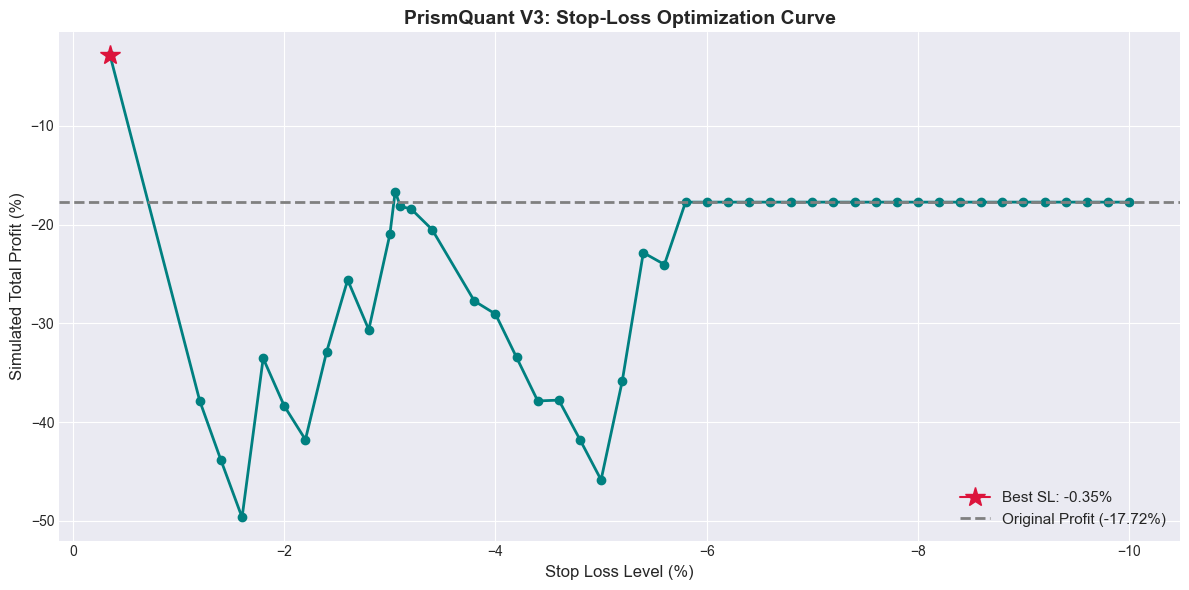

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def optimize_stop_loss():
    # 1. 파일 경로 및 데이터 로드
    # file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_V3_OKX_BTCUSDT.P_2026-02-24_1m_0.004.csv'
    file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-24_1m_0.004.csv'


    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ 파일을 찾을 수 없습니다. 경로를 확인해주세요:\n{file_path}")
        return

    # 💡 수정된 부분: 영문 컬럼명으로 매핑
    COL_PROFIT = 'Net P&L %'
    COL_MAE = 'Adverse excursion %'

    # 컬럼 존재 여부 확인
    if COL_PROFIT not in df.columns or COL_MAE not in df.columns:
        print(f"❌ 필수 컬럼이 없습니다. 현재 컬럼명: {df.columns.tolist()}")
        return

    # 원본 수익 합계 및 승률 계산
    orig_total = df[COL_PROFIT].sum()
    orig_win_rate = (df[COL_PROFIT] > 0).mean() * 100

    def run_sl_analysis(target_sl):
        sim_df = df.copy()
        
        # MAE가 target_sl보다 작거나 같으면 target_sl(손절가)로 수익을 대체
        sim_df['Simulated_Profit'] = np.where(
            sim_df[COL_MAE] <= target_sl, 
            target_sl, 
            sim_df[COL_PROFIT]
        )
        
        sim_total = sim_df['Simulated_Profit'].sum()
        sim_win_rate = (sim_df['Simulated_Profit'] > 0).mean() * 100
        stop_loss_tripped = (sim_df[COL_MAE] <= target_sl).sum()
        
        return {
            "SL(%)": target_sl,
            "Sim_Total(%)": sim_total,
            "Improvement(%p)": sim_total - orig_total,
            "Sim_WinRate(%)": sim_win_rate,
            "Stop_Count": stop_loss_tripped
        }

    # 2. 분석할 손절가 후보군
    sl_candidates = [
        -0.35, -1.2, -1.4, -1.6, -1.8, -2.0, -2.2, -2.4, -2.6, -2.8, -3.0, -3.1, -3.05,
        -3.2, -3.4, -3.8, -4.0, -4.2, -4.4, -4.6, -4.8, -5.0, -5.2, -5.4, -5.6, -5.8, 
        -6.0, -6.2, -6.4, -6.6, -6.8, -7.0, -7.2, -7.4, -7.6, -7.8, -8.0, -8.2, -8.4, 
        -8.6, -8.8, -9.0, -9.2, -9.4, -9.6, -9.8, -10.0
    ]
    sl_candidates = sorted(sl_candidates)

    # 3. 모든 후보군에 대해 분석 실행 및 데이터프레임화
    results = [run_sl_analysis(sl) for sl in sl_candidates]
    results_df = pd.DataFrame(results)

    # 4. 텍스트 리포트 출력
    print("=" * 70)
    print(" 🛡️ PRISMQUANT V3 : STOP-LOSS (SL) OPTIMIZATION REPORT")
    print("=" * 70)
    print(f" [원본 데이터 상태]")
    print(f"  • 노스탑(No-SL) 총 수익: {orig_total:.2f}%")
    print(f"  • 노스탑(No-SL) 승률  : {orig_win_rate:.1f}%\n")
    
    print(f"{'손절가(%)':>8} | {'시뮬총수익':>10} | {'수익개선':>10} | {'승률':>8} | {'손절횟수':>8}")
    print("-" * 70)
    
    for _, row in results_df.iterrows():
        status = "✅" if row['Improvement(%p)'] > 0 else "❌"
        print(f"{row['SL(%)']:>8.2f}% | {row['Sim_Total(%)']:>9.2f}% | {row['Improvement(%p)']:>9.2f}%p | {row['Sim_WinRate(%)']:>7.1f}% | {row['Stop_Count']:>6.0f}회 {status}")

    # 5. 최적의 손절가(Best SL) 자동 추출
    best_row = results_df.loc[results_df['Sim_Total(%)'].idxmax()]
    
    print("=" * 70)
    print(" 🏆 [최적 손절가(BEST SL) 분석 결과]")
    print(f"  • 가장 추천하는 손절선: {best_row['SL(%)']:.2f}%")
    print(f"  • 예상 총 수익        : {best_row['Sim_Total(%)']:.2f}% (기존 대비 {best_row['Improvement(%p)']:+.2f}%p 개선)")
    print(f"  • 이때의 승률         : {best_row['Sim_WinRate(%)']:.1f}%")
    print(f"  • 손절 발생 횟수      : {int(best_row['Stop_Count'])}회")
    print("=" * 70)

    # 6. 손절가 vs 시뮬레이션 수익 그래프 시각화
    plt.figure(figsize=(12, 6))
    plt.style.use('seaborn-v0_8-darkgrid')
    
    plt.plot(results_df['SL(%)'], results_df['Sim_Total(%)'], marker='o', linestyle='-', color='teal', linewidth=2, markersize=6)
    
    # 최적점 표시 (빨간 별)
    plt.plot(best_row['SL(%)'], best_row['Sim_Total(%)'], marker='*', color='crimson', markersize=15, label=f"Best SL: {best_row['SL(%)']:.2f}%")
    
    # 원본 수익선 표시 (점선)
    plt.axhline(y=orig_total, color='gray', linestyle='--', linewidth=2, label=f"Original Profit ({orig_total:.2f}%)")
    
    plt.title('PrismQuant V3: Stop-Loss Optimization Curve', fontsize=14, fontweight='bold')
    plt.xlabel('Stop Loss Level (%)', fontsize=12)
    plt.ylabel('Simulated Total Profit (%)', fontsize=12)
    plt.gca().invert_xaxis()
    plt.legend(loc='lower right', fontsize=11)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    optimize_stop_loss()


 🎯 PRISMQUANT V7 : ENTRY QUALITY ANALYSIS REPORT
 [타점 기초 통계] - 총 진입 횟수: 78회
  • 평균 순행폭(MFE) : +0.99% (중간값: +0.84%)
  • 평균 역행폭(MAE) : -2.00% (중간값: -1.66%)
  • 평균 E-Ratio     : 0.49 ⚠️ 개선 필요
  • 중간값 E-Ratio   : 0.51 (아웃라이어 영향을 제외한 실제 체감 우위)
-----------------------------------------------------------------
 [타점 퀄리티 진단 (역행폭 기준)]
  ✨ 칼타점 비율 (MAE > -1.0%) : 33.3% (26회)
  💀 심해 타점 비율 (MAE < -3.0%): 20.5% (16회)



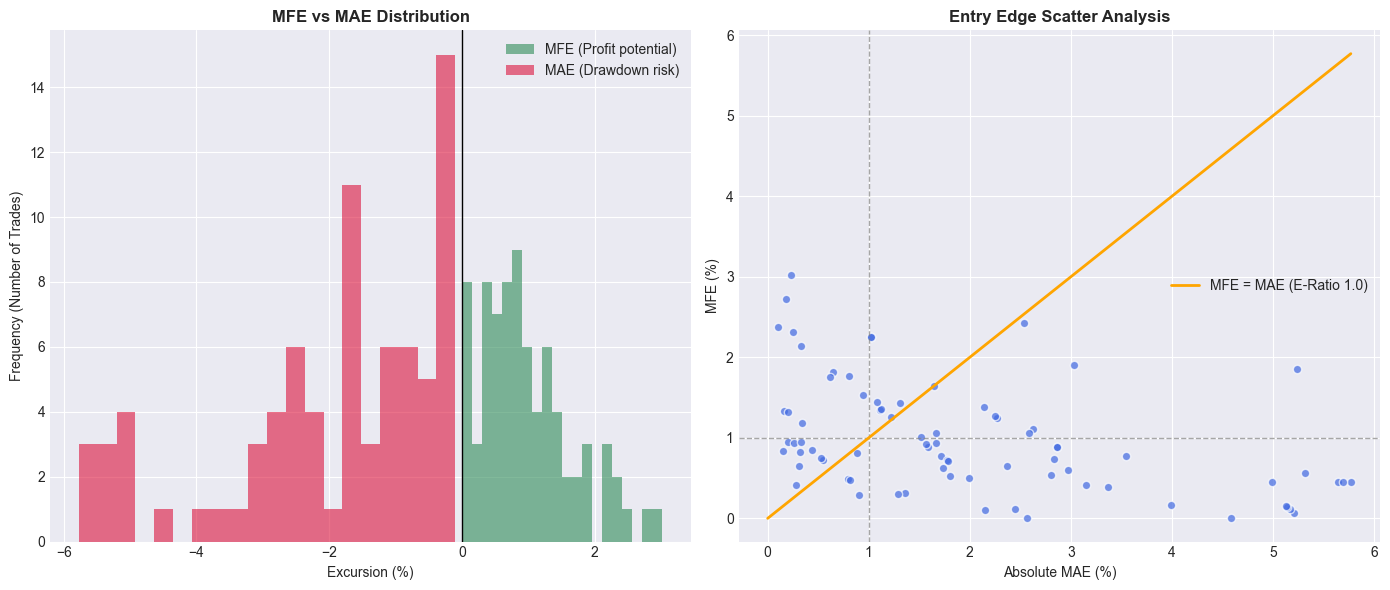

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def evaluate_entry_quality():
    # 1. 파일 경로 (최근에 사용하신 v7 파일 경로 적용)
    # file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_V3_OKX_BTCUSDT.P_2026-02-24_1m_0.004.csv'
    file_path = '/Users/minseok/Documents/PrismQuant/data/PrismQuant_ICE_Strategy_inverse_v7_OKX_BTCUSDT.P_2026-02-24_1m_0.004.csv'
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ 파일을 찾을 수 없습니다. 경로를 확인해주세요:\n{file_path}")
        return

    # 2. 필수 컬럼 매핑
    COL_TYPE = 'Type'
    COL_MFE = 'Favorable excursion %'
    COL_MAE = 'Adverse excursion %'
    COL_PROFIT = 'Net P&L %'

    if not all(col in df.columns for col in [COL_TYPE, COL_MFE, COL_MAE, COL_PROFIT]):
        print(f"❌ 필수 컬럼이 누락되었습니다. 현재 컬럼: {df.columns.tolist()}")
        return

    # 3. 진입(Entry) 데이터만 필터링
    # 'Entry long' 또는 'Entry short' 모두 포함되도록 처리
    entries = df[df[COL_TYPE].astype(str).str.contains('Entry')].copy()
    
    if entries.empty:
        print("❌ 'Entry' 키워드가 포함된 데이터가 없습니다.")
        return

    total_trades = len(entries)
    
    # 데이터 클렌징 (결측치 제거 및 MAE 절대값 처리)
    mfe_series = pd.to_numeric(entries[COL_MFE], errors='coerce').dropna()
    mae_series = pd.to_numeric(entries[COL_MAE], errors='coerce').dropna().abs()

    # 4. 핵심 통계 계산
    mfe_mean = mfe_series.mean()
    mae_mean = mae_series.mean()
    mfe_median = mfe_series.median()
    mae_median = mae_series.median()
    
    e_ratio_mean = mfe_mean / mae_mean if mae_mean != 0 else np.inf
    e_ratio_median = mfe_median / mae_median if mae_median != 0 else np.inf

    # 5. 타점 퀄리티 분류 (가상 시나리오)
    # 조건 1: 칼타점 (진입 후 -1% 이상 안 빠지고 바로 수익 나는 경우)
    sharp_entries = entries[pd.to_numeric(entries[COL_MAE], errors='coerce') >= -1.0]
    # 조건 2: 고통받는 타점 (진입 후 -3% 이상 깊게 빠지는 경우)
    painful_entries = entries[pd.to_numeric(entries[COL_MAE], errors='coerce') <= -3.0]

    # 6. 프로페셔널 타점 분석 리포트 출력
    print("\n" + "="*65)
    print(" 🎯 PRISMQUANT V7 : ENTRY QUALITY ANALYSIS REPORT")
    print("="*65)
    print(f" [타점 기초 통계] - 총 진입 횟수: {total_trades:,}회")
    print(f"  • 평균 순행폭(MFE) : +{mfe_mean:.2f}% (중간값: +{mfe_median:.2f}%)")
    print(f"  • 평균 역행폭(MAE) : -{mae_mean:.2f}% (중간값: -{mae_median:.2f}%)")
    
    edge_eval = "✅ 우수" if e_ratio_mean >= 1.0 else "⚠️ 개선 필요"
    print(f"  • 평균 E-Ratio     : {e_ratio_mean:.2f} {edge_eval}")
    print(f"  • 중간값 E-Ratio   : {e_ratio_median:.2f} (아웃라이어 영향을 제외한 실제 체감 우위)")
    print("-" * 65)
    
    print(f" [타점 퀄리티 진단 (역행폭 기준)]")
    sharp_pct = len(sharp_entries) / total_trades * 100
    pain_pct = len(painful_entries) / total_trades * 100
    
    print(f"  ✨ 칼타점 비율 (MAE > -1.0%) : {sharp_pct:.1f}% ({len(sharp_entries)}회)")
    print(f"  💀 심해 타점 비율 (MAE < -3.0%): {pain_pct:.1f}% ({len(painful_entries)}회)")
    
    if pain_pct > 30:
        print("\n  💡 코멘트: 진입 후 깊게 물리는 비율이 높습니다. 진입 조건을 더 깐깐하게")
        print("            필터링하거나, 진입 시점을 한 템포 늦추는 것을 권장합니다.")
    elif sharp_pct > 50:
        print("\n  💡 코멘트: 타점이 매우 정교합니다! 레버리지를 높이거나")
        print("            초기 비중을 실어 공격적으로 운영해볼 만합니다.")
    print("="*65 + "\n")

    # 7. MFE & MAE 밀도 분포 시각화 (Density Plot)
    plt.figure(figsize=(14, 6))
    plt.style.use('seaborn-v0_8-darkgrid')

    # 서브플롯 1: MFE / MAE 분포 히스토그램
    plt.subplot(1, 2, 1)
    plt.hist(mfe_series, bins=20, alpha=0.6, color='seagreen', label='MFE (Profit potential)')
    # MAE는 원래 음수이므로 음수 그대로 히스토그램에 표시하여 좌우 대비를 줌
    plt.hist(pd.to_numeric(entries[COL_MAE], errors='coerce').dropna(), bins=20, alpha=0.6, color='crimson', label='MAE (Drawdown risk)')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.title('MFE vs MAE Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Excursion (%)')
    plt.ylabel('Frequency (Number of Trades)')
    plt.legend()

    # 서브플롯 2: 진입점 산점도 분석
    plt.subplot(1, 2, 2)
    plt.scatter(pd.to_numeric(entries[COL_MAE], errors='coerce').dropna().abs(), mfe_series, alpha=0.7, c='royalblue', edgecolors='w')
    
    # 기준선 긋기
    plt.axvline(x=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    # 대각선 (MFE = MAE 선) : 이 선 위에 있으면 순행이 역행보다 큰 좋은 타점
    max_val = max(mfe_series.max(), mae_series.max())
    plt.plot([0, max_val], [0, max_val], color='orange', linestyle='-', linewidth=2, label='MFE = MAE (E-Ratio 1.0)')
    
    plt.title('Entry Edge Scatter Analysis', fontsize=12, fontweight='bold')
    plt.xlabel('Absolute MAE (%)')
    plt.ylabel('MFE (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    evaluate_entry_quality()